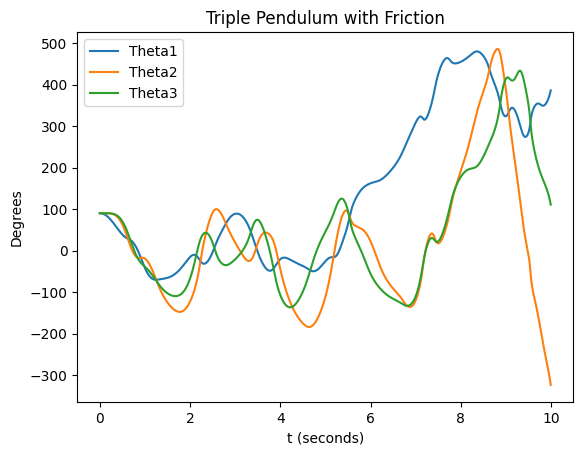

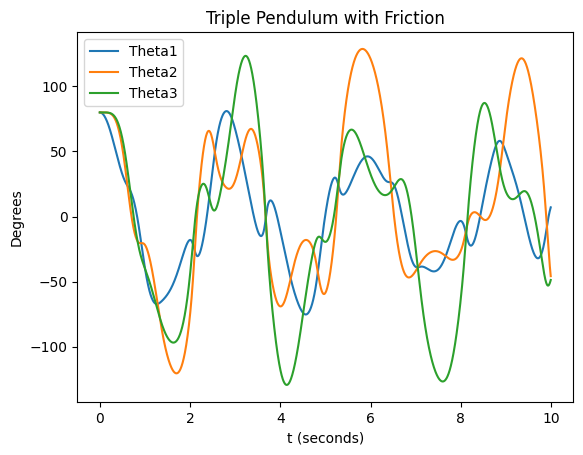

{'90_90_90': array([[0.29159625, 0.51108856, 0.39775485],
       [0.29158348, 0.51108856, 0.39775485],
       [0.29154518, 0.51108856, 0.39775485],
       ...,
       [0.82091201, 0.00924863, 0.44405562],
       [0.82503863, 0.00467236, 0.43914211],
       [0.82936672, 0.        , 0.43395441]]), '80_80_80': array([[0.99341147, 0.80432367, 0.82817701],
       [0.9933672 , 0.80432367, 0.82817701],
       [0.99323439, 0.80432367, 0.828177  ],
       ...,
       [0.51883255, 0.31435834, 0.3139023 ],
       [0.52284761, 0.30687365, 0.31629753],
       [0.5266534 , 0.29958815, 0.31887868]])}


In [1]:
from __future__ import division, print_function
from math import sin, pi
import numpy as np
from pylab import plot, xlabel, ylabel, show
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi, radians
from numpy import array, arange, zeros_like
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
from numpy import array

# Constants
g = 9.81  # Acceleration due to gravity
L1, L2, L3 = 1.0, 1.0, 1.0  # Lengths of pendulums
m1, m2, m3 = 1.0, 1.0, 1.0  # Masses of pendulums

# Friction/damping coefficients
damping1 = 0.05
damping2 = 0.05
damping3 = 0.05

def f(q, t):
    '''Triple Pendulum equation of motion with friction'''
    theta1, omega1, theta2, omega2, theta3, omega3 = q

    delta12 = theta1 - theta2
    delta13 = theta1 - theta3
    delta23 = theta2 - theta3

    denom1 = L1 * (2 * m1 + m2 + m3 - m2 * cos(2 * delta12) - m3 * cos(2 * delta13))
    denom2 = L2 * (2 * m1 + m2 + m3 - m2 * cos(2 * delta12) - m3 * cos(2 * delta23))
    denom3 = L3 * (2 * m1 + m2 + m3 - m3 * cos(2 * delta13))

    ftheta1 = omega1
    ftheta2 = omega2
    ftheta3 = omega3

    fomega1 = (-g * (2 * m1 + m2 + m3) * sin(theta1)
               - m2 * g * sin(theta1 - 2 * theta2)
               - m3 * g * sin(theta1 - 2 * theta3)
               - 2 * sin(delta12) * m2 * (omega2**2 * L2 + omega1**2 * L1 * cos(delta12))
               - 2 * sin(delta13) * m3 * (omega3**2 * L3 + omega1**2 * L1 * cos(delta13))
               - damping1 * omega1) / denom1

    fomega2 = (2 * sin(delta12) * (omega1**2 * L1 * (m1 + m2 + m3)
                                   + g * (m1 + m2 + m3) * cos(theta1)
                                   + omega2**2 * L2 * m2 * cos(delta12)
                                   + omega3**2 * L3 * m3 * cos(delta13))
               - damping2 * omega2) / denom2

    fomega3 = (2 * sin(delta13) * (omega1**2 * L1 * (m1 + m2 + m3)
                                   + g * (m1 + m2 + m3) * cos(theta1)
                                   + omega2**2 * L2 * m2 * cos(delta23)
                                   + omega3**2 * L3 * m3 * cos(delta13))
               - damping3 * omega3) / denom3

    return np.array([ftheta1, fomega1, ftheta2, fomega2, ftheta3, fomega3], float)

# Time parameters
a, b = 0.0, 10.0
N = 2000
h = (b - a) / N
tpoints = np.arange(a, b, h)

# Initial conditions (angles in degrees, converted to radians)
angles = [[90, 90, 90], [80, 80, 80]]

for x in angles:
    theta1_points = np.zeros_like(tpoints)
    theta2_points = np.zeros_like(tpoints)
    theta3_points = np.zeros_like(tpoints)

    # Initial angles (convert to radians)
    r = np.array([x[0] * pi / 180, 0, x[1] * pi / 180, 0, x[2] * pi / 180, 0], float)

    for i, t in enumerate(tpoints):
        theta1_points[i] = r[0] * 180 / pi
        theta2_points[i] = r[2] * 180 / pi
        theta3_points[i] = r[4] * 180 / pi

        # Runge-Kutta method
        k1 = h * f(r, t)
        k2 = h * f(r + 0.5 * k1, t + 0.5 * h)
        k3 = h * f(r + 0.5 * k2, t + 0.5 * h)
        k4 = h * f(r + k3, t + h)
        r += (k1 + 2 * k2 + 2 * k3 + k4) / 6

    plt.plot(tpoints, theta1_points, label='Theta1')
    plt.plot(tpoints, theta2_points, label='Theta2')
    plt.plot(tpoints, theta3_points, label='Theta3')
    plt.title("Triple Pendulum with Friction")
    plt.xlabel("t (seconds)")
    plt.ylabel("Degrees")
    plt.legend()
    plt.show()

    data = np.stack((theta1_points, theta2_points, theta3_points), axis=1)
    np.save(f'triple_pendulum_data_{str(x[0])}_{str(x[1])}_{str(x[2])}.npy', data)

# Define the dataset class
class QuadraticDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)  # Shape (N, 2)
        self.y = torch.tensor(y, dtype=torch.float32)  # Shape (N, 2)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

data = {}

for i in angles:
  loaded_data = np.load(f'triple_pendulum_data_{str(i[0])}_{str(i[1])}_{str(i[2])}.npy')
  scaler = MinMaxScaler()
  data_ = scaler.fit_transform(loaded_data)
  data[f'{str(i[0])}_{str(i[1])}_{str(i[2])}'] = data_

print(data)

def create_io_triple(data):
    x, x_1, x_2, x_3, y_1, y_2, y_3 = [], [], [], [], [], [], []

    for starting in data:
        starting_theta_1_degrees = int(starting.split("_")[0])
        starting_theta_2_degrees = int(starting.split("_")[1])
        starting_theta_3_degrees = int(starting.split("_")[2])

        starting_theta_1 = starting_theta_1_degrees * pi /180
        starting_theta_2 = starting_theta_2_degrees * pi /180
        starting_theta_3 = starting_theta_3_degrees * pi /180

        angle_data = data[starting]
        for i in range(len(angle_data)):
            x.append(tpoints[i])
            x_1.append(starting_theta_1)
            x_2.append(starting_theta_2)
            x_3.append(starting_theta_3)
            y_1.append(angle_data[i][0])
            y_2.append(angle_data[i][1])
            y_3.append(angle_data[i][2])
    return x, x_1, x_2, x_3, y_1, y_2, y_3

x, x_1, x_2, x_3, y_1, y_2, y_3 = create_io_triple(data)

# Normalize data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

x_combined = np.vstack([x_1, x_2, x_3, x]).T
scaler_x = MinMaxScaler()
x_scaled = scaler_x.fit_transform(x_combined)

y_combined = np.vstack([y_1, y_2, y_3]).T
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y_combined)

# Create dataset and dataloaders
dataset = QuadraticDataset(x_scaled, y_scaled)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [2]:
# check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Feed-Forward Neural Network (FFNN) model class
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Hyperparameters
input_size = 4  # Time + 3 angles
hidden_size = 64
output_size = 3  # Predict 3 angles
model = FeedForwardNN(input_size, hidden_size, output_size).to(device)

loss_function = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function for FFNN
def train_model_ffnn(model, train_loader, test_loader, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            y_pred = model(inputs)
            loss = loss_function(y_pred, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                y_pred = model(inputs)
                val_loss += loss_function(y_pred, targets).item()

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(test_loader))
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    return train_losses, val_losses

# Train the model for 200 epochs
train_model_ffnn(model, train_loader, test_loader, 200)

# Evaluate the model
model.eval()
y_preds = []
y_trues = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        y_pred = model(inputs)
        y_preds.append(y_pred.cpu().numpy())
        y_trues.append(targets.cpu().numpy())

# Convert predictions and targets to arrays
y_preds = np.concatenate(y_preds, axis=0)
y_trues = np.concatenate(y_trues, axis=0)

# Rescale predictions back to original scale
y_preds_rescaled = scaler_y.inverse_transform(y_preds)
y_trues_rescaled = scaler_y.inverse_transform(y_trues)

# Calculate RMSE & R^2 Score
rmse = np.sqrt(mean_squared_error(y_trues_rescaled, y_preds_rescaled))
print(f"RMSE: {rmse:.4f}")
r2 = r2_score(y_trues_rescaled, y_preds_rescaled)
print(f"R^2 Score: {r2:.4f}")

Epoch 1/200, Train Loss: 0.0616, Validation Loss: 0.0485
Epoch 2/200, Train Loss: 0.0466, Validation Loss: 0.0476
Epoch 3/200, Train Loss: 0.0454, Validation Loss: 0.0452
Epoch 4/200, Train Loss: 0.0446, Validation Loss: 0.0437
Epoch 5/200, Train Loss: 0.0440, Validation Loss: 0.0444
Epoch 6/200, Train Loss: 0.0433, Validation Loss: 0.0422
Epoch 7/200, Train Loss: 0.0426, Validation Loss: 0.0438
Epoch 8/200, Train Loss: 0.0420, Validation Loss: 0.0415
Epoch 9/200, Train Loss: 0.0413, Validation Loss: 0.0410
Epoch 10/200, Train Loss: 0.0407, Validation Loss: 0.0401
Epoch 11/200, Train Loss: 0.0400, Validation Loss: 0.0397
Epoch 12/200, Train Loss: 0.0397, Validation Loss: 0.0394
Epoch 13/200, Train Loss: 0.0390, Validation Loss: 0.0397
Epoch 14/200, Train Loss: 0.0380, Validation Loss: 0.0386
Epoch 15/200, Train Loss: 0.0369, Validation Loss: 0.0373
Epoch 16/200, Train Loss: 0.0359, Validation Loss: 0.0352
Epoch 17/200, Train Loss: 0.0347, Validation Loss: 0.0336
Epoch 18/200, Train Los

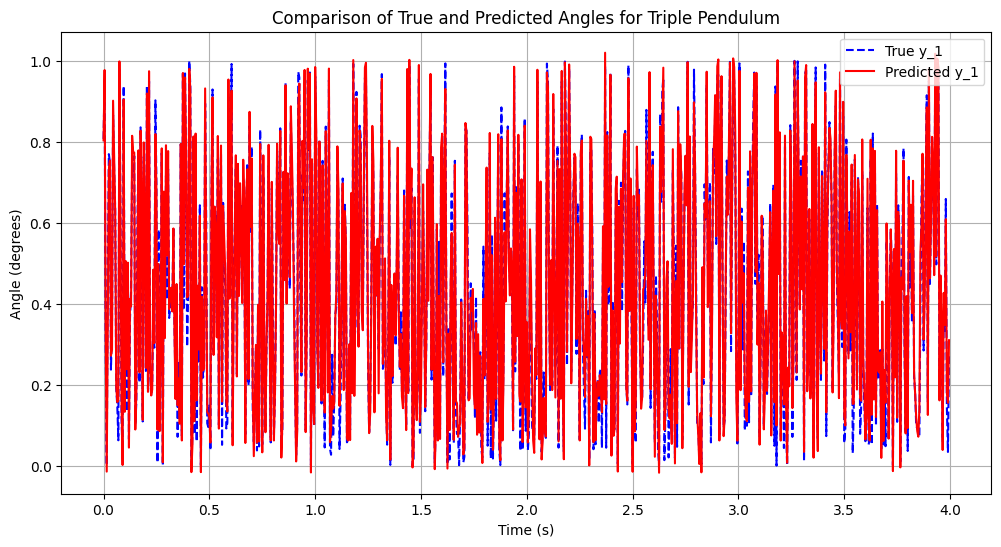

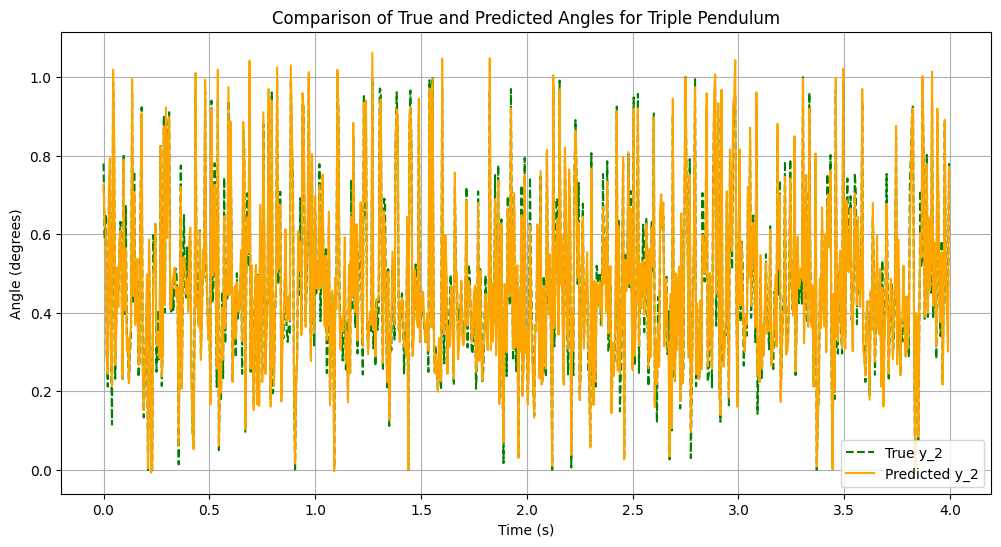

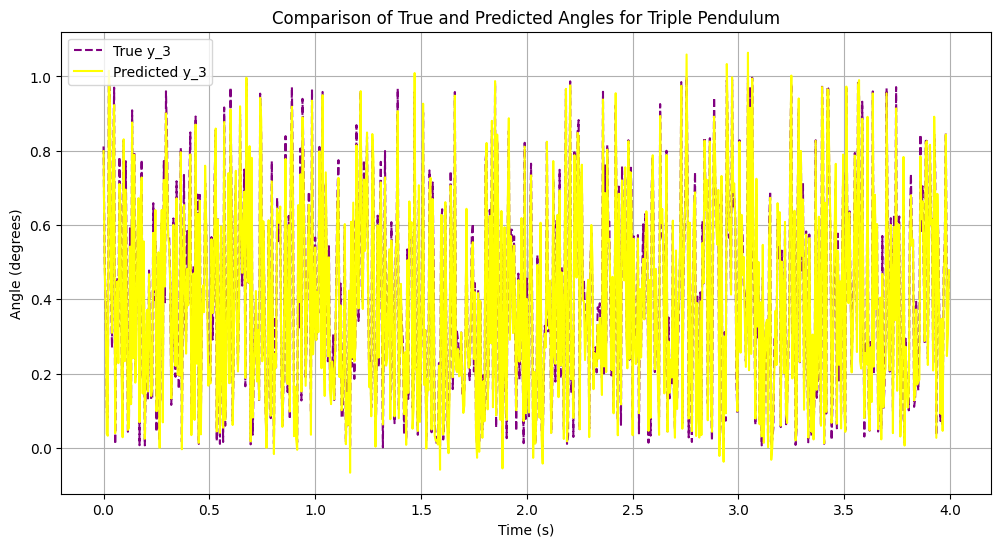

In [3]:
# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(x[0:800], y_trues_rescaled[:, 0], label='True y_1', color='blue', linestyle='--')
plt.plot(x[0:800], y_preds_rescaled[:, 0], label='Predicted y_1', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.title('Comparison of True and Predicted Angles for Triple Pendulum')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(x[0:800], y_trues_rescaled[:, 1], label='True y_2', color='green', linestyle='--')
plt.plot(x[0:800], y_preds_rescaled[:, 1], label='Predicted y_2', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.title('Comparison of True and Predicted Angles for Triple Pendulum')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(x[0:800], y_trues_rescaled[:, 2], label='True y_3', color='purple', linestyle='--')
plt.plot(x[0:800], y_preds_rescaled[:, 2], label='Predicted y_3', color='yellow')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.title('Comparison of True and Predicted Angles for Triple Pendulum')
plt.legend()
plt.grid(True)
plt.show()